In [0]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/FINAL-TF2-FILES/TF_2_Notebooks_and_Data/DATA/RSCCASN.csv',index_col='DATE',parse_dates=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [0]:
df.columns = ['Sales']

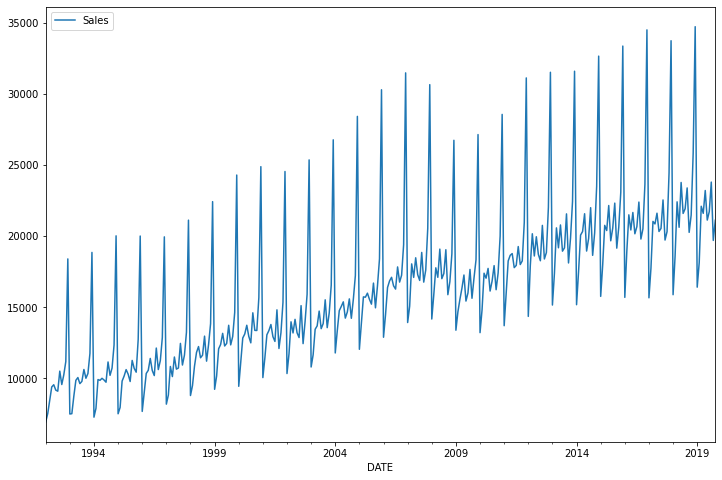

In [6]:
df.plot(figsize=(12,8))

In [0]:
test_size = 12

In [0]:
test_ind = len(df)- test_size

In [0]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [10]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381


In [11]:
test

,Sales
DATE,
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410
2019-02-01,18134
2019-03-01,22093
2019-04-01,21597
2019-05-01,23200
2019-06-01,21123
2019-07-01,21714


In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
scaler = MinMaxScaler()

In [14]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [0]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [0]:
from sklearn.metrics import mean_squared_error

In [0]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=2)

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [0]:
from tensorflow.keras.callbacks import EarlyStopping

In [0]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [0]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length-1, batch_size=2)

In [0]:
true_predictions=[]

In [0]:
performance = 0

In [0]:
class create_model:

  def __init__(self,n_features,n_neurons,n_epochs,n_length,n_generator,n_validation_generator,n_early_stop,n_predictions,n_test,n_performance,n_scaled_train,n_scaled_test):
    self.n_features = n_features
    self.n_neurons = n_neurons
    self.n_epochs = n_epochs
    self.n_length = n_length
    self.n_generator = n_generator
    self.n_validation_generator = n_validation_generator
    self.n_early_stop = n_early_stop
    self.n_predictions = n_predictions
    self.n_test = n_test
    self.n_performance = n_performance
    self.n_scaled_train = n_scaled_train
    self.n_scaled_test = n_scaled_test
  
  def predict_model(self,first_eval_batch=[],current_batch=[],test_predictions=[]):
    length = self.n_length
    features = self.n_features
    neurons = self.n_neurons
    generator=self.n_generator
    epochs = self.n_epochs
    validation_generator = self.n_validation_generator
    early_stop = self.n_early_stop
    scaled_train = self.n_scaled_train
    scaled_test = self.n_scaled_test
    test= self.n_test
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(length,features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=2)
    validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length-1, batch_size=2)
    early_stop = EarlyStopping(monitor='val_loss',patience=2)
    model.fit_generator(generator= generator,epochs=epochs,
                      validation_data=validation_generator,
                      callbacks=early_stop)
    first_eval_batch = scaled_train[-length:]
    current_batch = first_eval_batch.reshape((1,length,features))
    for i in range(len(test)):
      # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
      current_pred = model.predict(current_batch)[0]
    
      # store prediction
      test_predictions.append(current_pred) 
    
      # update batch to now include prediction and drop first value
      current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    try:
      self.n_test.drop('Predictions',axis=1)
      true_predictions = scaler.inverse_transform(test_predictions)
      self.n_test['Predictions'] = true_predictions
      self.n_performance = np.sqrt(mean_squared_error(self.n_test["Sales"],self.n_test["Predictions"]))

    except:  
      true_predictions = scaler.inverse_transform(test_predictions)
      self.n_test['Predictions'] = true_predictions
      self.n_performance = np.sqrt(mean_squared_error(self.n_test["Sales"],self.n_test["Predictions"]))


In [0]:
n_model = create_model(n_features= 1, n_neurons= 150, n_epochs = 20,n_length = 12,n_generator= generator,n_validation_generator=validation_generator,n_early_stop=early_stop,n_predictions =true_predictions,n_test=test,n_performance=performance,n_scaled_train=scaled_train,n_scaled_test = scaled_test )

In [27]:
n_model.predict_model()

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
155/155 [==============================] - 2s 11ms/step - loss: 0.0277 - val_loss: 0.0094
Epoch 2/20
155/155 [==============================] - 1s 9ms/step - loss: 0.0197 - val_loss: 0.0235
Epoch 3/20
155/155 [==============================] - 1s 9ms/step - loss: 0.0151 - val_loss: 9.8500e-04
Epoch 4/20
155/155 [==============================] - 2s 10ms/step - loss: 0.0085 - val_loss: 0.0045
Epoch 5/20
155/155 [==============================] - 1s 10ms/step - loss: 0.0061 - val_loss: 0.0264


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


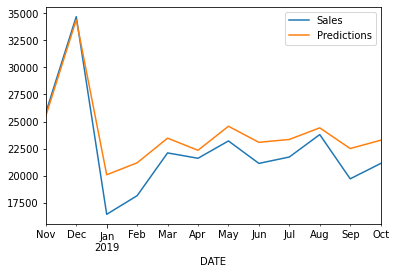

In [28]:
n_model.n_test.plot()

In [29]:
n_model.n_performance

1967.0750677942062